# Sentence Classification

## Background

In a scenario where an algorithm classifies sectors for different texts, it is important to measure its classification. This makes it possible to understand the worst assertiveness rate and propose solutions for improvement.
This project aims to develop a model that classifies different subjects for sentences and evaluates their quality.

The project was made possible according to the [proposed planning](../docs/planning.md)

## Measure of Success

As we want to understand which are the worst classifications, metrics such as Recall and Precision are able to correctly measure the correct classifications, in this case we will use F1-Score which harmonizes the metrics. In addition, we will analyze the confusion matrix and AUC Curve to identify the classifications for each label.

# 1.0 Imports

In [1]:
import warnings
import pandas                            as pd
import string
import re
import numpy                             as np

from collections import Counter
import seaborn                           as sns
import matplotlib.pyplot                 as plt

import nltk
from nltk.stem                          import WordNetLemmatizer
from nltk.corpus                        import stopwords, wordnet

from sklearn.preprocessing              import MultiLabelBinarizer
from sklearn.model_selection            import train_test_split
from sklearn.metrics                    import precision_score, recall_score, f1_score, confusion_matrix

from wordcloud                          import WordCloud

from keras.preprocessing.text           import Tokenizer
from keras.preprocessing.sequence       import pad_sequences
import tensorflow                       as tf
from tensorflow.keras                   import backend as K
from keras                              import saving
from tensorflow.keras.layers            import Input, SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models            import Model
from tensorflow.keras.regularizers      import l1_l2
from keras.callbacks                    import EarlyStopping
from keras.models                       import load_model

## 1.1 Load Data

In [2]:
df_raw = pd.read_csv("../data/01_raw/dataset.csv")

## 1.2 Helper Funtions

In [3]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 24
    sns.set()

    warnings.filterwarnings('ignore')
    return None


def lemmatize_word(word, lemmatizer):
    lemma = lemmatizer.lemmatize(word, pos=wordnet.VERB)
    return lemmatizer.lemmatize(lemma, pos=wordnet.NOUN)


def process_text(text, lemmatizer, portuguese_stopword):
    text = text.lower()

    text = ''.join([char for char in text if char not in string.punctuation])
    
    words = text.split()
    filtered_and_lemmatized_words = [lemmatize_word(word, lemmatizer) for word in words if word.lower() not in portuguese_stopword]
    text = ' '.join(filtered_and_lemmatized_words)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


@saving.register_keras_serializable()
def f2_score(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    fbeta_score = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return K.mean(fbeta_score)


def sample_prediction_multilabel(model, tokenizer, validation_data, original_data, mlb, MAX_SEQUENCE_LENGTH, num_samples=5, threshold=0.5):
    sample_indices = np.random.choice(validation_data.index, size=num_samples, replace=False)

    sample_texts_processed = validation_data.loc[sample_indices, 'sentence'].tolist()
    sample_texts_original = original_data.loc[sample_indices, 'sentence'].tolist()

    sample_true_categories = validation_data.loc[sample_indices, mlb.classes_].values

    sequences = tokenizer.texts_to_sequences(sample_texts_processed)
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    predictions = model.predict(data)
    
    predicted_categories = (predictions > threshold).astype(int)
    
    for i, (text, true_cats, pred_cats) in enumerate(zip(sample_texts_original, sample_true_categories, predicted_categories)):
        print('-' * 100)
        print(f"Sample {i+1}")
        print(f"Original Text: {text}")
        print(f"True Categories: {[mlb.classes_[i] for i, val in enumerate(true_cats) if val == 1]}")
        print(f"Predicted Categories: {[mlb.classes_[i] for i, val in enumerate(pred_cats) if val == 1]}")
    print('-' * 100)
    return None


def evaluate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return None


def plot_multilabel_confusion_matrix(y_true, y_pred, labels, figsize=(15, 10)):
    n_labels = y_true.shape[1]
    
    fig, axs = plt.subplots(int(np.ceil(n_labels / 3)), 3, figsize=figsize)
    axs = axs.flatten()

    for i in range(n_labels):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i])
        axs[i].set_title(labels[i])
        axs[i].set_xlabel('Predicted Label')
        axs[i].set_ylabel('True Label')

    for i in range(n_labels, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

    
notebook_settings()

# 2.0 Data Descrition

In [4]:
data_description = df_raw.copy()

data_description.shape

(521, 2)

## 2.1 Check NaNs

In [5]:
data_description.isna().sum()

sentence    0
category    0
dtype: int64

## 2.2 Data Types

In [6]:
data_description.dtypes

sentence    object
category    object
dtype: object

- We don't have any visible problems with the data, so let's do some more in-depth analysis.

# 3.0 Analyse Data

In [7]:
data_analysis = data_description.copy()

In [8]:
data_analysis['category'].value_counts(normalize=True)

category
orgão público              0.269
educação                   0.205
indústrias                 0.171
varejo                     0.163
finanças                   0.104
finanças,varejo            0.025
educação,orgão público     0.017
indústrias,varejo          0.013
educação,indústrias        0.010
finanças,orgão público     0.008
finanças,indústrias        0.006
indústrias,orgão público   0.004
educação,finanças          0.004
varejo,indústrias          0.002
Name: proportion, dtype: float64

In [9]:
data_analysis['category'].value_counts()

category
orgão público               140
educação                    107
indústrias                   89
varejo                       85
finanças                     54
finanças,varejo              13
educação,orgão público        9
indústrias,varejo             7
educação,indústrias           5
finanças,orgão público        4
finanças,indústrias           3
indústrias,orgão público      2
educação,finanças             2
varejo,indústrias             1
Name: count, dtype: int64

- We have unbalanced data, which is to be expected, but we also have some classes such as 1 occurrence, which can get in the way of dividing up the data; if we need to improve the model, we can apply class balancing.

In [10]:
data_analysis['sentence_lenght'] = data_analysis['sentence'].apply(lambda x: len(str(x).split()))
data_analysis['sentence_lenght'].sort_values(ascending=False)

210    21
193    20
303    20
507    20
362    20
       ..
64      3
386     3
491     3
244     3
212     3
Name: sentence_lenght, Length: 521, dtype: int64

In [11]:
data_analysis.iloc[210, 0]

'Para se enquadrar nesta categoria é necessário apresentar o comprovante de produtor rural, o ITR – Imposto sobre propriedade Territorial Rural.'

- We don't have long sentences, which makes it easier for models not to have to maintain a long context.

## 3.1 Most Used Words

In [12]:
all_texts = ''.join(data_analysis['sentence'])

words = all_texts.split()

word_counts = Counter(words)
df_words = pd.DataFrame(word_counts.items(), columns=['word','count'])


df_words.sort_values(by='count', ascending=False).head(20)

,word,count
22,de,351
5,e,145
24,do,106
110,o,99
30,a,93
42,para,89
3,em,72
20,da,65
120,com,54
216,no,40


- We have a lot of `stopwords`, which is to be expected, so we'll deal with those cases.

# 4.0 Data Processing

In [13]:
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
portuguese_stopword = set(stopwords.words('portuguese'))

# here we remove the stop words
data_analysis['sentence'] = data_analysis['sentence'].apply(lambda row: process_text(row, lemmatizer, portuguese_stopword))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SamuelOliveiraAlvesd\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SamuelOliveiraAlvesd\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


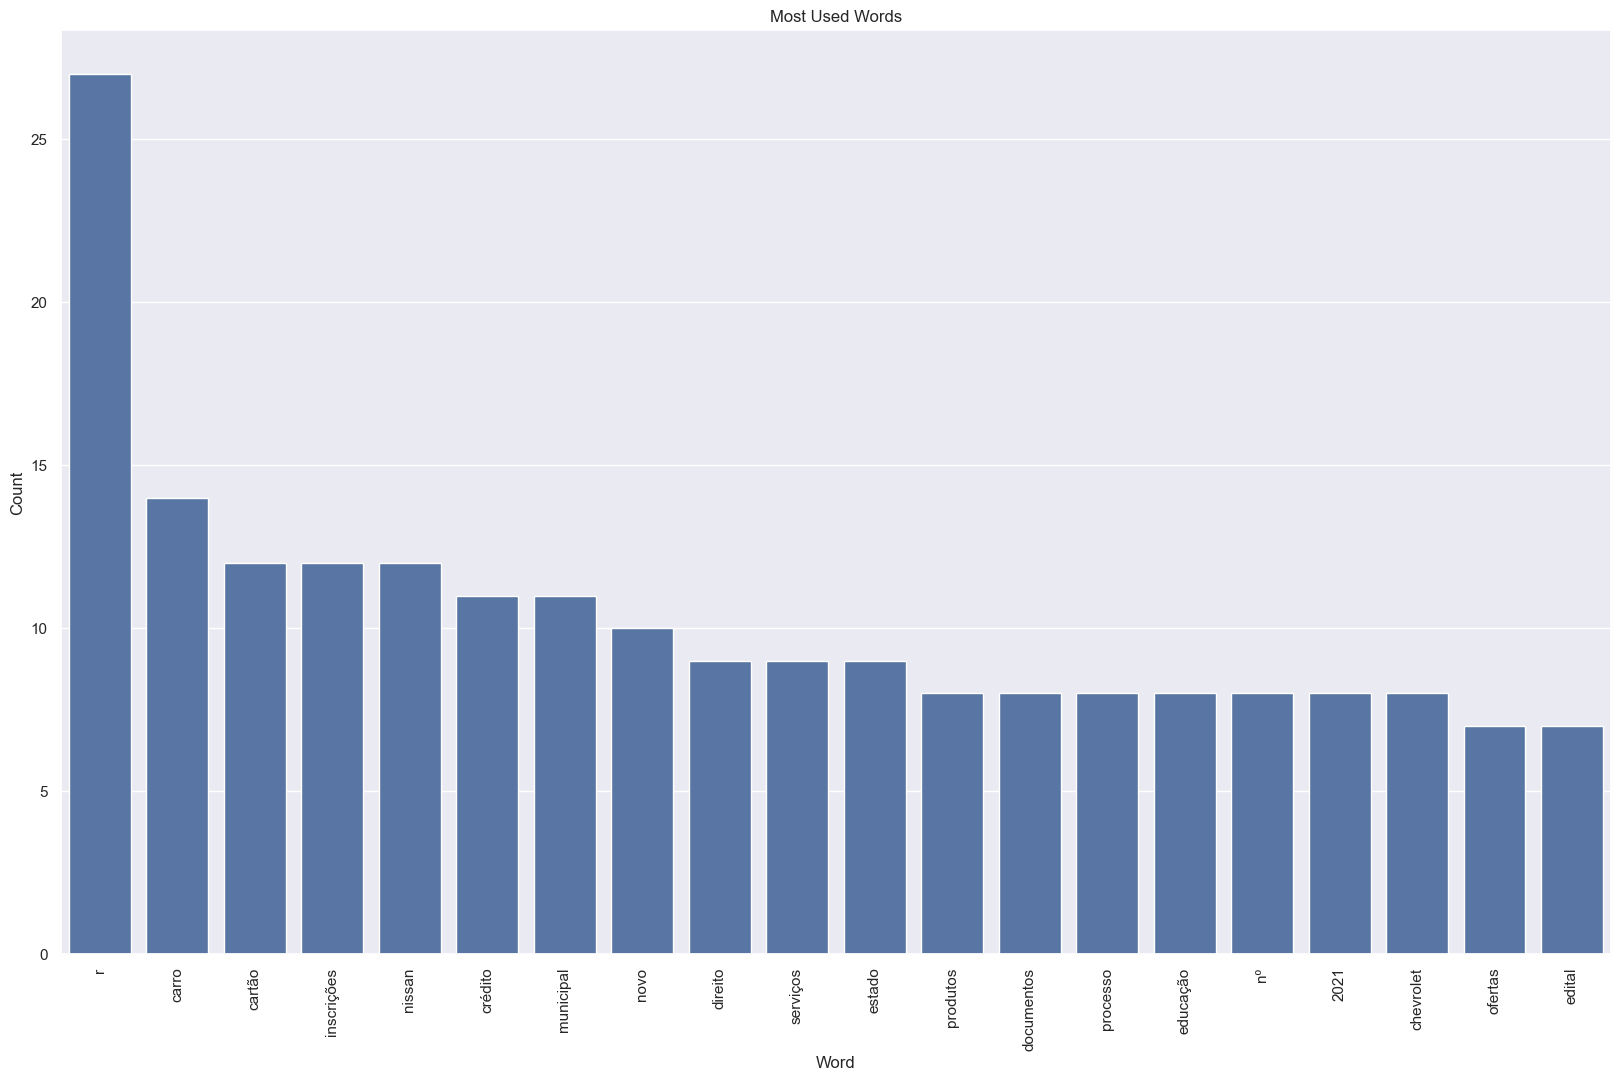

In [14]:
all_texts_filtered = ''.join(data_analysis['sentence'])

words_filtered = all_texts_filtered.split()

word_counts_filtered = Counter(words_filtered)
df_words_filtered = pd.DataFrame(word_counts_filtered.items(), columns=['word','count'])

top_20_words = df_words_filtered.sort_values(by='count', ascending=False).head(20)

sns.barplot(top_20_words, x='word', y='count')
plt.xticks(rotation=90);
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Used Words');

 - Most of the words seem significant to represent the categorization, although we have some dirt like `r` or `2021` we won't apply such detailed treatments in order to balance the time available to complete the project.

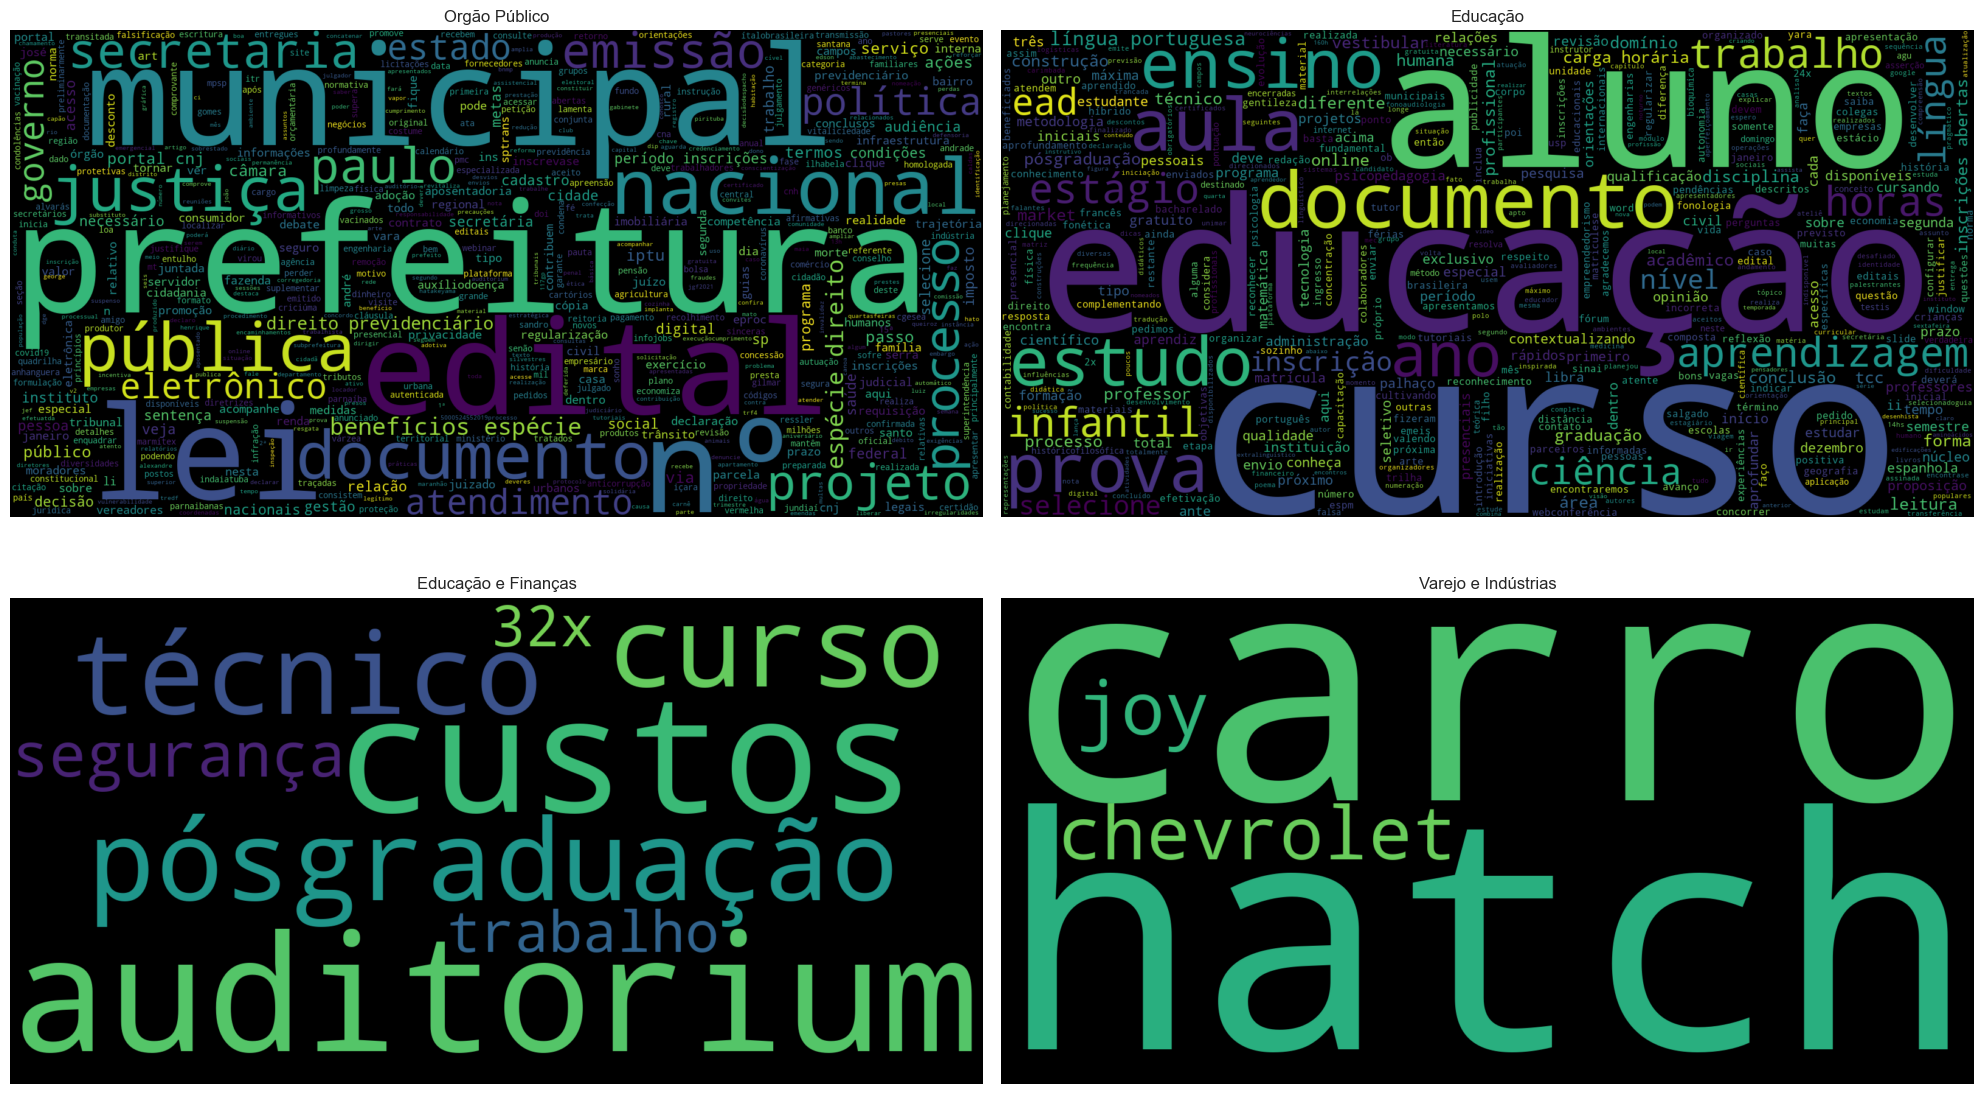

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

for ax in axs.flat:
    ax.axis("off")

wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(data_analysis[data_analysis.category == 'orgão público'].sentence))
axs[0, 0].imshow(wc, interpolation='bilinear')
axs[0, 0].set_title('Orgão Público')

wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(data_analysis[data_analysis.category == 'educação'].sentence))
axs[0, 1].imshow(wc, interpolation='bilinear')
axs[0, 1].set_title('Educação')

wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(data_analysis[data_analysis.category == 'educação,finanças'].sentence))
axs[1, 0].imshow(wc, interpolation='bilinear')
axs[1, 0].set_title('Educação e Finanças')

wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(data_analysis[data_analysis.category == 'varejo,indústrias'].sentence))
axs[1, 1].imshow(wc, interpolation='bilinear')
axs[1, 1].set_title('Varejo e Indústrias')

plt.tight_layout()
plt.show()

- Here we can analyze some classes and understand the impact of the imbalance where the classes with the fewest examples have a high chance of error.

- In contrast, the most common words have good contexts to help with correct classification.

# 5.0 Data Preparation

In [16]:
data_preparation = data_analysis.copy()
data_preparation = data_preparation.loc[:,['sentence','category']]

data_preparation['category'] = data_preparation['category'].apply(lambda x: x.split(','))

train, validation = train_test_split(data_preparation, test_size=0.3, random_state=42)

- Here we have a problem due to the lack of unbalancing where a class has only one instance and so it is not possible to separate the class from the instance, If it's necessary to improve performance, we can perform oversampling and carry out the correct separation of the data.

### 5.1 Response Variable Encoding

In [17]:
mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(train['category'])

y_validation = mlb.transform(validation['category'])

train = train.reset_index(drop=True)
train_categories = pd.DataFrame(y_train, columns=mlb.classes_)

train = pd.concat([train.drop(['category'], axis=1), train_categories], axis=1)

validation = validation.reset_index(drop=True)
validation_categories = pd.DataFrame(y_validation, columns=mlb.classes_)

validation = pd.concat([validation.drop(['category'], axis=1), validation_categories], axis=1)

- Now we have the response variable prepared to make predictions of one or more categories.

### 5.2 Tokenization

In [18]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 512

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

tokenizer.fit_on_texts(train['sentence'])

sequences_train = tokenizer.texts_to_sequences(train['sentence'])
sequences_validation = tokenizer.texts_to_sequences(validation['sentence'])

X_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_validation = pad_sequences(sequences_validation, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index

- Now let's segment the texts into tokenization; since it involves some parameters, this session can be used to improve the model's performance.

### 5.3 Word Embedding

- You can download the Stanford embedding from this link:

In [19]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [20]:
# import zipfile

# GLOVE_PATH = '../data/06_models/glove.6B.zip'

# with zipfile.ZipFile(GLOVE_PATH, 'r') as zip_ref:
#     zip_ref.extractall('../data/06_models/')

In [21]:
GLOVE_EMB = '../data/06_models/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


embedding_layer = tf.keras.layers.Embedding(input_dim=MAX_NUM_WORDS,
                                          output_dim=EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

Found 400000 word vectors.


- Finally, we will apply an embedding. I will use a pre-trained model from Stanford University. One of the limitations of this transfer learning is that we are using a model trained primarily in English, and therefore the choice of models also contributes significantly to performance.

# 6.0 Machine Learning

- We listed some models in the planning, but initially, we will use only one to validate.

In [22]:
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_layer')

embedded_sequences = embedding_layer(input_layer)

spatial_dropout = SpatialDropout1D(0.2, name='spatial_dropout')(embedded_sequences)

conv1 = Conv1D(64, 5, activation='relu', name='conv1')(spatial_dropout)

bi_lstm = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2), name='bi_lstm')(conv1)

dense1 = Dense(512, activation='relu', name='dense1')(bi_lstm)
dropout = Dropout(0.5, name='dropout')(dense1)
dense2 = Dense(512, activation='relu', name='dense2')(dropout)

output_layer = Dense(5, activation='sigmoid', name='output_layer')(dense2)

model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f2_score])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 300)          3000000   
                                                                 
 spatial_dropout (SpatialDr  (None, 512, 300)          0         
 opout1D)                                                        
                                                                 
 conv1 (Conv1D)              (None, 508, 64)           96064     
                                                                 
 bi_lstm (Bidirectional)     (None, 128)               66048     
                                                                 
 dense1 (Dense)              (None, 512)               66048     
                                                             

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

Epoch 1/50
12/12 [==============================] - 13s 820ms/step - loss: 0.6033 - f2_score: 0.0291 - val_loss: 0.5568 - val_f2_score: 0.0000e+00
Epoch 2/50
12/12 [==============================] - 9s 770ms/step - loss: 0.5300 - f2_score: 0.0000e+00 - val_loss: 0.5322 - val_f2_score: 0.0000e+00
Epoch 3/50
12/12 [==============================] - 9s 791ms/step - loss: 0.5027 - f2_score: 0.0000e+00 - val_loss: 0.5055 - val_f2_score: 0.0000e+00
Epoch 4/50
12/12 [==============================] - 9s 776ms/step - loss: 0.4499 - f2_score: 0.0880 - val_loss: 0.4593 - val_f2_score: 0.1527
Epoch 5/50
12/12 [==============================] - 9s 746ms/step - loss: 0.3833 - f2_score: 0.3232 - val_loss: 0.4200 - val_f2_score: 0.2120
Epoch 6/50
12/12 [==============================] - 10s 818ms/step - loss: 0.3293 - f2_score: 0.4665 - val_loss: 0.3895 - val_f2_score: 0.3932
Epoch 7/50
12/12 [==============================] - 9s 785ms/step - loss: 0.2431 - f2_score: 0.6839 - val_loss: 0.4125 - val_f

In [24]:
# model.save('../data/06_models/lstm_model.keras')

# model = load_model('../data/06_models/lstm_model.keras')

In [25]:
sample_prediction_multilabel(model, tokenizer, validation, train, mlb, MAX_SEQUENCE_LENGTH, num_samples=5, threshold=0.5)

1/1 [==============================] - 0s 335ms/step
----------------------------------------------------------------------------------------------------
Sample 1
Original Text: secretaria governo promove webinar câmara ítalobrasileira comércio indústria agricultura
True Categories: ['educação']
Predicted Categories: ['educação']
----------------------------------------------------------------------------------------------------
Sample 2
Original Text: conclusos decisãodespacho
True Categories: ['varejo']
Predicted Categories: ['varejo']
----------------------------------------------------------------------------------------------------
Sample 3
Original Text: 16042021 0959 131 processo suspenso sobrestado decisão judicial aguarda decisão instância superior
True Categories: ['indústrias', 'varejo']
Predicted Categories: ['varejo']
----------------------------------------------------------------------------------------------------
Sample 4
Original Text: coelho chocolate leite belga fri

- We can test some sentences and see how the model tries to predict the category.

## 6.1 Evaluate Metrics

In [26]:
y_pred = model.predict(X_validation)
y_pred_classes = (y_pred > 0.5).astype(int)
evaluate_metrics(y_validation, y_pred_classes)

5/5 [==============================] - 0s 71ms/step
Precision: 0.7634
Recall: 0.3851
F1 Score: 0.4986


- Considering the granularity of categories, it is a satisfactory result, but we're in the first cycle, so we're going to make some improvements and increase the metrics.

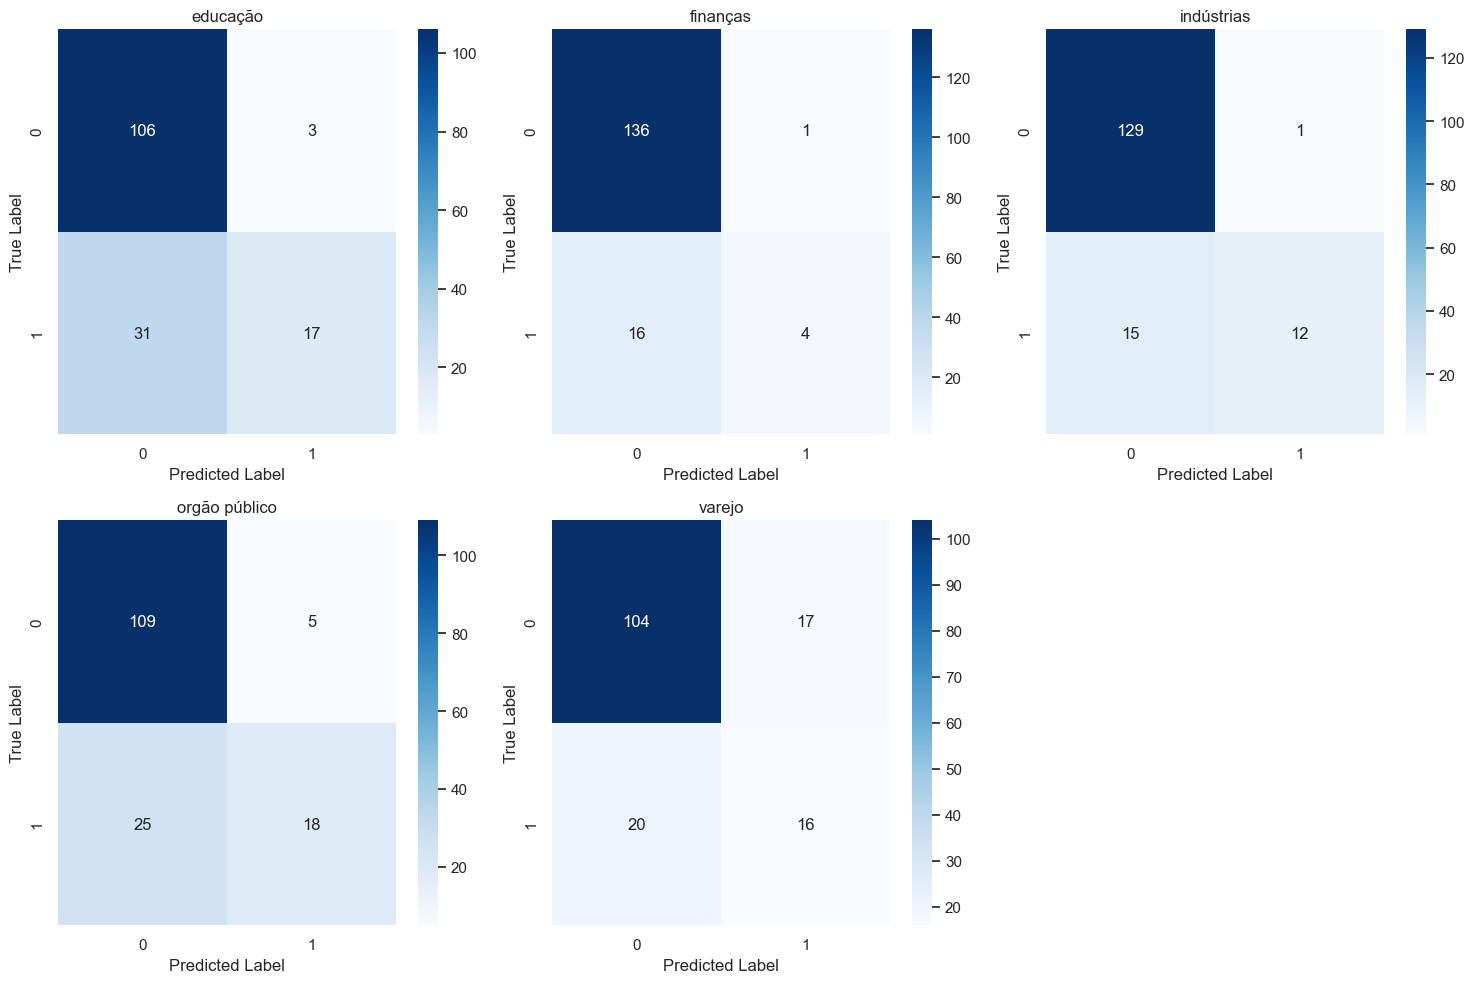

In [27]:
plot_multilabel_confusion_matrix(y_validation, y_pred_classes, mlb.classes_)

## Next Steps

- Improve Fine Tunning
- Find best threshold with auc curve.
- Create function with permit input sample text to model predict.
- Api deploy.